In [74]:
import copy
import csv
import cv2 as cv
import feret
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import os
import pandas as pd
import pickle
from scipy.ndimage import binary_fill_holes, distance_transform_edt
from skimage.draw import polygon, circle_perimeter_aa
from skimage.measure import label, regionprops
from skimage.morphology import convex_hull_image
import shapely
import trimesh

# Preamble

In [2]:
def get_projection(ms, normal):
    normal = np.array(normal)
    normal = normal/np.linalg.norm(normal)
    m = copy.deepcopy(ms)
    dir_rot = normal + np.array([1,0,0])
    if np.linalg.norm(dir_rot) < 1e-6:
        dir_rot = np.array([1,0,0])
    m.apply_transform(trimesh.transformations.rotation_matrix(math.pi, dir_rot))
    m.apply_transform(trimesh.transformations.projection_matrix((0,0,0),(1,0,0)))
    polygons = [
        shapely.geometry.Polygon(triangle[:,1:])
        for index_triangle, triangle in enumerate(m.triangles)
        if np.linalg.norm(m.face_normals[index_triangle] - np.array([1,0,0])) < 1e-6
    ]
    poly_merged = shapely.ops.unary_union(polygons)
    return poly_merged

In [3]:
def get_projection_along_axis(mesh, axis='z'):
    ms = mesh.copy()
    if axis == 'x':
        dim_to_keep = [1, 2]  # Keep Y and Z dimensions for X projection
    elif axis == 'y':
        dim_to_keep = [0, 2]  # Keep X and Z dimensions for Y projection
    else:  # Default to 'z'
        dim_to_keep = [0, 1]  # Keep X and Y dimensions for Z projection
    polygons = [
        shapely.geometry.Polygon(triangle[:, dim_to_keep])
        for triangle in ms.triangles
    ]
    poly_merged = shapely.ops.unary_union(polygons)
    return poly_merged

In [4]:
def extract_polygon(projection):
    if type(projection) == shapely.geometry.multipolygon.MultiPolygon:
        polygon_ = shapely.Polygon()
        for polygon__ in [*projection.geoms]:
            if polygon__.length > polygon_.length:
                polygon_ = polygon__
        projection = polygon_
    return projection

# 3D Particle

In [28]:
file = "example/101.stl"

In [29]:
ms = trimesh.load_mesh(file)

In [30]:
type(ms)

trimesh.base.Trimesh

## Properties

In [31]:
ms.bounds

array([[ 0.5,  0.5,  0.5],
       [48.5, 64.5, 49.5]])

In [32]:
ms.extents

array([48., 64., 49.])

In [33]:
ms.is_watertight

True

In [34]:
ms.is_convex

False

## 3D Representations

### Untreated Particle

NameError: name 'dimensions' is not defined

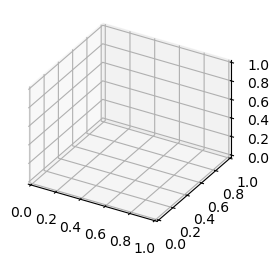

In [12]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.add_collection3d(Poly3DCollection(ms.triangles, shade=True, facecolors="white"))

ax.set_xlim(0, dimensions[1][0])
ax.set_ylim(0, dimensions[1][1])
ax.set_zlim(0, dimensions[1][2])

ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z")

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))

ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0);

#### with Projections

In [31]:
ms = trimesh.load_mesh(file)
ms.vertices -= ms.center_mass
ms.vertices += [45, 45, 45]
dimensions = [[0, 0, 0], [90, 90, 90]]

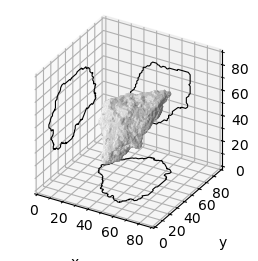

In [32]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.add_collection3d(Poly3DCollection(ms.triangles, shade=True, facecolors="white"))

projection_xy = get_projection_along_axis(ms, 'z')
x, y = projection_xy.exterior.xy
z = np.zeros_like(x)
ax.plot(x, y, z, 'k', lw=0.8)

projection_xz = get_projection_along_axis(ms, 'y')
x, z = projection_xz.exterior.xy
y = np.ones_like(x) * dimensions[1][1]
ax.plot(x, y, z, 'k', lw=0.8)

projection_yz = get_projection_along_axis(ms, 'x')
y, z = projection_yz.exterior.xy
x = np.zeros_like(y)
ax.plot(x, y, z, 'k', lw=0.8)

ax.set_xlim(0, dimensions[1][0])
ax.set_ylim(0, dimensions[1][1])
ax.set_zlim(0, dimensions[1][2])

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0)

ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z");

### Oriented Bounding Box

In [34]:
ms = trimesh.load_mesh(file)
ms.vertices -= ms.center_mass
ms.vertices += [45, 45, 45]

ms.bounding_box_oriented.bounds

array([[ 6.0891134 ,  4.94200848,  5.92492741],
       [91.9016933 , 88.387395  , 75.60545633]])

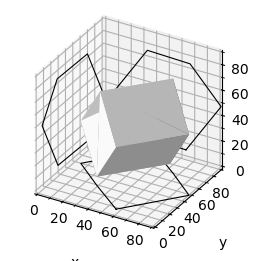

In [36]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.add_collection3d(Poly3DCollection(ms.bounding_box_oriented.triangles, shade=True, facecolors="white"))

projection_xy = get_projection_along_axis(ms.bounding_box_oriented, 'z')
x, y = projection_xy.exterior.xy
z = np.zeros_like(x)
ax.plot(x, y, z, 'k', lw=0.8)

projection_xz = get_projection_along_axis(ms.bounding_box_oriented, 'y')
x, z = projection_xz.exterior.xy
y = np.ones_like(x) * dimensions[1][1]
ax.plot(x, y, z, 'k', lw=0.8)

projection_yz = get_projection_along_axis(ms.bounding_box_oriented, 'x')
y, z = projection_yz.exterior.xy
x = np.zeros_like(y)
ax.plot(x, y, z, 'k', lw=0.8)

ax.set_xlim(0, dimensions[1][0])
ax.set_ylim(0, dimensions[1][1])
ax.set_zlim(0, dimensions[1][2])

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))

ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0)
ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z");

### Principal Inertia Transform

In [37]:
ms = trimesh.load_mesh(file)
ms.apply_transform(ms.principal_inertia_transform)
ms.vertices -= ms.center_mass
ms.vertices += [45, 45, 45]

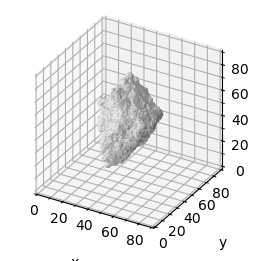

In [38]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.add_collection3d(Poly3DCollection(ms.triangles, shade=True, facecolors="white"))

ax.set_xlim(0, dimensions[1][0])
ax.set_ylim(0, dimensions[1][1])
ax.set_zlim(0, dimensions[1][2])

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))

ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0)
ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z");

#### with Projections

In [39]:
ms = trimesh.load_mesh(file)
ms.apply_transform(ms.principal_inertia_transform)
ms.vertices -= ms.center_mass
ms.vertices += [45, 45, 45]

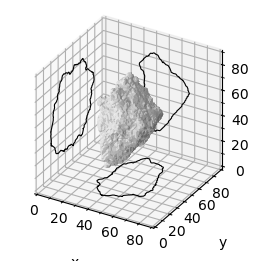

In [40]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.add_collection3d(Poly3DCollection(ms.triangles, shade=True, facecolors="white"))

projection_xy = get_projection_along_axis(ms, 'z')
x, y = projection_xy.exterior.xy
z = np.zeros_like(x)
ax.plot(x, y, z, 'k', lw=0.8)

projection_xz = get_projection_along_axis(ms, 'y')
x, z = projection_xz.exterior.xy
y = np.ones_like(x) * dimensions[1][1]
ax.plot(x, y, z, 'k', lw=0.8)

projection_yz = get_projection_along_axis(ms, 'x')
y, z = projection_yz.exterior.xy
x = np.zeros_like(y)
ax.plot(x, y, z, 'k', lw=0.8)

ax.set_xlim(0, dimensions[1][0])
ax.set_ylim(0, dimensions[1][1])
ax.set_zlim(0, dimensions[1][2])

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0)

ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z");

### Bounding Box

In [43]:
ms = trimesh.load_mesh(file)
ms.apply_transform(ms.principal_inertia_transform)
ms.vertices -= ms.center_mass
ms.vertices += [45, 45, 45]

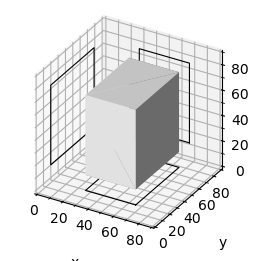

In [53]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.add_collection3d(Poly3DCollection(ms.bounding_box.triangles, shade=True, facecolors="white"))

projection_xy = get_projection_along_axis(ms.bounding_box, 'z')
projection_xy = extract_polygon(projection_xy)
x, y = projection_xy.exterior.xy
z = np.zeros_like(x)
ax.plot(x, y, z, 'k', lw=0.8)

projection_xz = get_projection_along_axis(ms.bounding_box, 'y')
projection_xz = extract_polygon(projection_xz)
x, z = projection_xz.exterior.xy
y = np.ones_like(x) * dimensions[1][1]
ax.plot(x, y, z, 'k', lw=0.8)

projection_yz = get_projection_along_axis(ms.bounding_box, 'x')
projection_yz = extract_polygon(projection_yz)
y, z = projection_yz.exterior.xy
x = np.zeros_like(y)
ax.plot(x, y, z, 'k', lw=0.8)

ax.set_xlim(dimensions[0][0], dimensions[1][0])
ax.set_ylim(dimensions[0][1], dimensions[1][1])
ax.set_zlim(dimensions[0][2], dimensions[1][2])

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))

ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0)
ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z");

In [54]:
ms.bounding_box.volume

146740.9066662306

### Convex Hull

In [55]:
ms = trimesh.load_mesh(file)
ms.vertices -= ms.bounds[0]
dimensions = ms.bounds

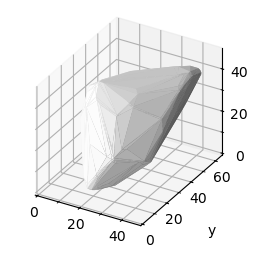

In [56]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.add_collection3d(Poly3DCollection(ms.convex_hull.triangles, shade=True, facecolors="white"))

ax.set_xlim(dimensions[0][0], dimensions[1][0])
ax.set_ylim(dimensions[0][1], dimensions[1][1])
ax.set_zlim(dimensions[0][2], dimensions[1][2])

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))

ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0)
ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z");

### Enclosing and Inscribed Spheres

#### Minimum Enclosing Sphere

In [63]:
ms = trimesh.load_mesh(file)
ms.vertices -= ms.bounds[0]
ms.vertices += [1.4, 2.1, 11.4]

In [64]:
bounding_sphere = ms.bounding_sphere
dimensions = bounding_sphere.bounds

dimensions

array([[-1.82002134e-02, -3.75879685e-02, -4.11593970e-02],
       [ 6.75375880e+01,  6.75182002e+01,  6.75146288e+01]])

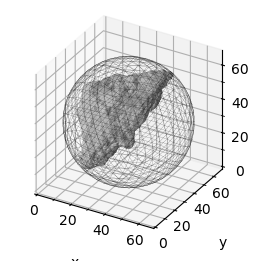

In [65]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.add_collection3d(Poly3DCollection(ms.triangles, shade=True, facecolors="lightgray"))
ax.add_collection3d(Poly3DCollection(bounding_sphere.triangles, edgecolors="k", alpha=0.0, facecolors="white", linewidths=0.05))

ax.set_xlim(0, dimensions[1][0])
ax.set_ylim(0, dimensions[1][1])
ax.set_zlim(0, dimensions[1][2])

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))

ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0)
ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z");

In [66]:
bounding_sphere.center, bounding_sphere.extents

(TrackedArray([33.75969388, 33.74030612, 33.73673469]),
 array([67.55578818, 67.55578818, 67.55578818]))

##### with Projections

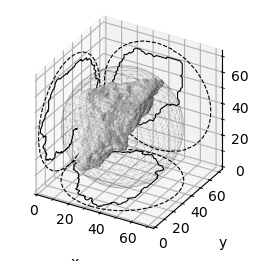

In [67]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.add_collection3d(Poly3DCollection(ms.triangles, shade=True, facecolors="white"))
ax.add_collection3d(Poly3DCollection(bounding_sphere.triangles, edgecolors="k", alpha=0.0, facecolors="white", linewidths=0.02))

for mesh, linestyle in zip([ms, bounding_sphere], ["solid", "dashed"]):
    projection_xy = get_projection_along_axis(mesh, 'z')
    x, y = projection_xy.exterior.xy
    z = np.zeros_like(x)
    ax.plot(x, y, z, 'k', lw=0.8, ls=linestyle)
    
    projection_xz = get_projection_along_axis(mesh, 'y')
    x, z = projection_xz.exterior.xy
    y = np.ones_like(x) * dimensions[1][1] + 5
    ax.plot(x, y, z, 'k', lw=0.8, ls=linestyle)
    
    projection_yz = get_projection_along_axis(mesh, 'x')
    y, z = projection_yz.exterior.xy
    x = np.zeros_like(y)
    ax.plot(x, y, z, 'k', lw=0.8, ls=linestyle)

ax.set_xlim(0, dimensions[1][0] + 5)
ax.set_ylim(0, dimensions[1][1] + 5)
ax.set_zlim(0, dimensions[1][2] + 5)

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0)

ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z");

##### Aligned Projections

In [68]:
ms = trimesh.load_mesh(file)
ms.apply_transform(ms.principal_inertia_transform)
ms.vertices -= ms.bounds[0]
ms.vertices += [29.2, 11.5, 6.3]

In [69]:
bounding_sphere = ms.bounding_sphere
dimensions = bounding_sphere.bounds

dimensions

array([[ 5.02924239,  5.03637408,  4.99133876],
       [72.58503057, 72.59216226, 72.54712694]])

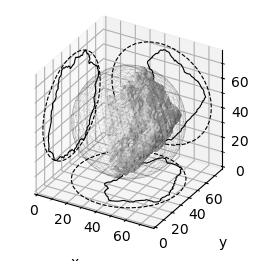

In [70]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.add_collection3d(Poly3DCollection(ms.triangles, shade=True, facecolors="white"))
ax.add_collection3d(Poly3DCollection(bounding_sphere.triangles, edgecolors="k", alpha=0.0, facecolors="white", linewidths=0.02))

for mesh, linestyle in zip([ms, bounding_sphere], ["solid", "dashed"]):
    projection_xy = get_projection_along_axis(mesh, 'z')
    x, y = projection_xy.exterior.xy
    z = np.zeros_like(x)
    ax.plot(x, y, z, 'k', lw=0.8, ls=linestyle)
    
    projection_xz = get_projection_along_axis(mesh, 'y')
    x, z = projection_xz.exterior.xy
    y = np.ones_like(x) * dimensions[1][1] + 5
    ax.plot(x, y, z, 'k', lw=0.8, ls=linestyle)
    
    projection_yz = get_projection_along_axis(mesh, 'x')
    y, z = projection_yz.exterior.xy
    x = np.zeros_like(y)
    ax.plot(x, y, z, 'k', lw=0.8, ls=linestyle)

ax.set_xlim(0, dimensions[1][0] + 5)
ax.set_ylim(0, dimensions[1][1] + 5)
ax.set_zlim(0, dimensions[1][2] + 5)

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0)

ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z");

#### Maximum Inscribed Sphere

##### Voxelization

In [74]:
ms = trimesh.load_mesh(file)
voxel_grid = ms.voxelized(pitch=1)
voxel_array = voxel_grid.matrix

In [75]:
dimensions = ms.bounds

dimensions, voxel_array.shape

(array([[ 0.5,  0.5,  0.5],
        [48.5, 64.5, 49.5]]),
 (49, 65, 51))

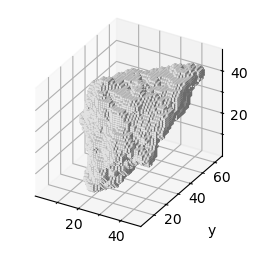

In [77]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.voxels(voxel_array, facecolors="white", edgecolor=None)

ax.set_xlim(dimensions[0][0], dimensions[1][0])
ax.set_ylim(dimensions[0][1], dimensions[1][1])
ax.set_zlim(dimensions[0][2], dimensions[1][2])

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))

ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0)
ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z");

But, ``trimesh``'s voxelization result is hollow...

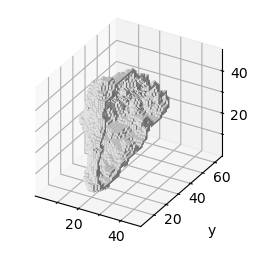

In [78]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.voxels(voxel_array[:25, :, :], facecolors="white", edgecolor=None)

ax.set_xlim(dimensions[0][0], dimensions[1][0])
ax.set_ylim(dimensions[0][1], dimensions[1][1])
ax.set_zlim(dimensions[0][2], dimensions[1][2])

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))

ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0)
ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z");

`scipy` can fix the hollow voxelization result:

In [79]:
filled_voxel_array = binary_fill_holes(voxel_array).astype(voxel_array.dtype)

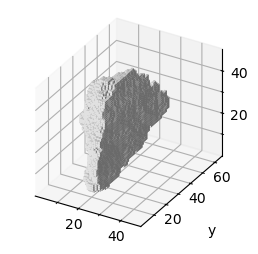

In [80]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.voxels(filled_voxel_array[:25, :, :], facecolors="white", edgecolor=None)

ax.set_xlim(dimensions[0][0], dimensions[1][0])
ax.set_ylim(dimensions[0][1], dimensions[1][1])
ax.set_zlim(dimensions[0][2], dimensions[1][2])

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))

ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0)
ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z");

##### Euclidean Distance Transform

In [81]:
dist_transform = distance_transform_edt(filled_voxel_array)
max_coord = np.unravel_index(np.argmax(dist_transform), dist_transform.shape)
max_radius = dist_transform[max_coord]

max_coord, max_radius

((24, 29, 28), 13.490737563232042)

In [82]:
inscribed_sphere = trimesh.primitives.Sphere(radius=max_radius, center=max_coord)

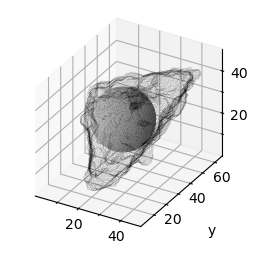

In [83]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.add_collection3d(Poly3DCollection(inscribed_sphere.triangles, shade=True, facecolors="lightgray"))
ax.add_collection3d(Poly3DCollection(ms.triangles, edgecolors="k", alpha=0.0, facecolors="white", linewidths=0.01))

ax.set_xlim(dimensions[0][0], dimensions[1][0])
ax.set_ylim(dimensions[0][1], dimensions[1][1])
ax.set_zlim(dimensions[0][2], dimensions[1][2])

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))

ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0)
ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z");

##### with Projections

In [84]:
ms = trimesh.load_mesh(file)
ms.vertices -= ms.bounds[0]
ms.vertices += [5, 5, 5]
dimensions = ms.bounds

dimensions

array([[ 5.,  5.,  5.],
       [53., 69., 54.]])

In [85]:
voxel_grid = ms.voxelized(pitch=1)
voxel_array = voxel_grid.matrix
filled_voxel_array = binary_fill_holes(voxel_array).astype(voxel_array.dtype)
dist_transform = distance_transform_edt(filled_voxel_array)
max_coord = np.unravel_index(np.argmax(dist_transform), dist_transform.shape)
max_radius = dist_transform[max_coord]
max_coord_ = tuple((a + b) for a, b in zip(max_coord, (5, 5, 5)))
inscribed_sphere = trimesh.primitives.Sphere(radius=max_radius, center=max_coord_)

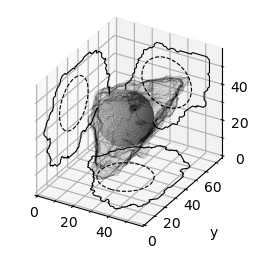

In [86]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.add_collection3d(Poly3DCollection(inscribed_sphere.triangles, shade=True, facecolors="lightgray"))
ax.add_collection3d(Poly3DCollection(ms.triangles, edgecolors="k", alpha=0.0, facecolors="white", linewidths=0.01))

for mesh, linestyle in zip([ms, inscribed_sphere], ["solid", "dashed"]):
    projection_xy = get_projection_along_axis(mesh, 'z')
    x, y = projection_xy.exterior.xy
    z = np.zeros_like(x)
    ax.plot(x, y, z, 'k', lw=0.8, ls=linestyle)
    
    projection_xz = get_projection_along_axis(mesh, 'y')
    x, z = projection_xz.exterior.xy
    y = np.ones_like(x) * dimensions[1][1] + 5
    ax.plot(x, y, z, 'k', lw=0.8, ls=linestyle)
    
    projection_yz = get_projection_along_axis(mesh, 'x')
    y, z = projection_yz.exterior.xy
    x = np.zeros_like(y)
    ax.plot(x, y, z, 'k', lw=0.8, ls=linestyle)

ax.set_xlim(0, dimensions[1][0] + 5)
ax.set_ylim(0, dimensions[1][1] + 5)
ax.set_zlim(0, dimensions[1][2] + 5)

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0)

ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z");

##### Aligned Projections

In [87]:
ms = trimesh.load_mesh(file)
ms.apply_transform(ms.principal_inertia_transform)
ms.vertices -= ms.bounds[0]
ms.vertices += [5, 5, 5]
dimensions = ms.bounds

dimensions

array([[ 5.        ,  5.        ,  5.        ],
       [44.51934247, 64.12928735, 67.79699228]])

In [88]:
voxel_grid = ms.voxelized(pitch=1)
voxel_array = voxel_grid.matrix
filled_voxel_array = binary_fill_holes(voxel_array).astype(voxel_array.dtype)
dist_transform = distance_transform_edt(filled_voxel_array)
max_coord = np.unravel_index(np.argmax(dist_transform), dist_transform.shape)
max_radius = dist_transform[max_coord]
max_coord_ = tuple(a + b for a, b in zip(max_coord, (5, 5, 5)))
inscribed_sphere = trimesh.primitives.Sphere(radius=max_radius, center=max_coord_)

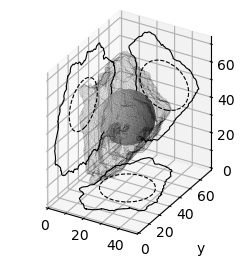

In [89]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.add_collection3d(Poly3DCollection(inscribed_sphere.triangles, shade=True, facecolors="lightgray"))
ax.add_collection3d(Poly3DCollection(ms.triangles, edgecolors="k", alpha=0.0, facecolors="white", linewidths=0.01))

for mesh, linestyle in zip([ms, inscribed_sphere], ["solid", "dashed"]):
    projection_xy = get_projection_along_axis(mesh, 'z')
    x, y = projection_xy.exterior.xy
    z = np.zeros_like(x)
    ax.plot(x, y, z, 'k', lw=0.8, ls=linestyle)
    
    projection_xz = get_projection_along_axis(mesh, 'y')
    x, z = projection_xz.exterior.xy
    y = np.ones_like(x) * dimensions[1][1] + 5
    ax.plot(x, y, z, 'k', lw=0.8, ls=linestyle)
    
    projection_yz = get_projection_along_axis(mesh, 'x')
    y, z = projection_yz.exterior.xy
    x = np.zeros_like(y)
    ax.plot(x, y, z, 'k', lw=0.8, ls=linestyle)

ax.set_xlim(0, dimensions[1][0] + 5)
ax.set_ylim(0, dimensions[1][1] + 5)
ax.set_zlim(0, dimensions[1][2] + 5)

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0)

ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z");

##### Higher Resolution of Voxelization

In [92]:
ms = trimesh.load_mesh(file)
ms.vertices -= ms.bounds[0]

In [93]:
## pitch --> resolution
## 0.5 --> twice as many voxels
pitch = 0.5

voxel_grid = ms.voxelized(pitch=pitch)
voxel_array = voxel_grid.matrix
filled_voxel_array = binary_fill_holes(voxel_array).astype(voxel_array.dtype)
dist_transform = distance_transform_edt(filled_voxel_array)
max_coord = np.unravel_index(np.argmax(dist_transform), dist_transform.shape)
max_radius = dist_transform[max_coord] * pitch
max_coord_ = np.array(max_coord) * pitch #tuple(a + b for a, b in zip(max_coord, (15, 5, 10)))
inscribed_sphere = trimesh.primitives.Sphere(radius=max_radius, center=max_coord_)

max_coord_, max_radius

(array([22. , 30. , 24.5]), 12.62933094031509)

In [94]:
pitch = 0.25

voxel_grid = ms.voxelized(pitch=pitch)
voxel_array = voxel_grid.matrix
filled_voxel_array = binary_fill_holes(voxel_array).astype(voxel_array.dtype)
dist_transform = distance_transform_edt(filled_voxel_array)
max_coord = np.unravel_index(np.argmax(dist_transform), dist_transform.shape)
max_radius = dist_transform[max_coord] * pitch
max_coord_ = np.array(max_coord) * pitch #tuple(a + b for a, b in zip(max_coord, (15, 5, 10)))
inscribed_sphere = trimesh.primitives.Sphere(radius=max_radius, center=max_coord_)

max_coord_, max_radius

(array([22.  , 30.25, 24.5 ]), 12.442367138129304)

Was ``((24, 29, 28), 13.490737563232042)``, so is somewhat more accurate now. But a pitch of ``0.5`` should be enough, as the resolution isn't any higher anyway.

# Static Image Analysis

## Fixed Position

In [35]:
ms = trimesh.load_mesh(file)

### Alignment

In [36]:
ms.vertices -= ms.center_mass
ms.apply_transform(ms.principal_inertia_transform)
dimensions = ms.bounds

dimensions

array([[-17.18147403, -27.88494283, -32.08712415],
       [ 22.33786844,  31.24434453,  30.70986813]])

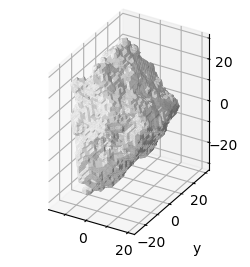

In [37]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.add_collection3d(Poly3DCollection(ms.triangles, shade=True, facecolors="white"))

ax.set_xlim(dimensions[0][0], dimensions[1][0])
ax.set_ylim(dimensions[0][1], dimensions[1][1])
ax.set_zlim(dimensions[0][2], dimensions[1][2])

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))

ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0)
ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z");

### Projection

In [38]:
# center at origin and align to principal axes
ms.vertices -= ms.center_mass
ms.apply_transform(ms.principal_inertia_transform);

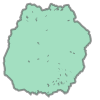

In [39]:
projection = get_projection(ms, normal=(1,0,0))

projection

In [40]:
projection.is_valid, projection.is_closed

(True, False)

Sometimes, the conversion will have produced multiple geometries in the STL file. In that case, the biggest contour is used.

In [41]:
projection = extract_polygon(projection)

In [42]:
x, y = projection.exterior.xy
x, y = np.array(x), np.array(y)
x, y = x.max() - x, -y
x, y = x - x.min(), y - y.min()

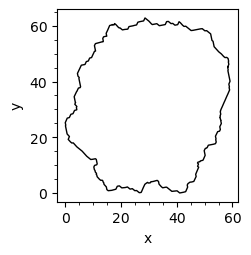

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.plot(x, y, lw=1, c="k")

ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y")

ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(5));

#### Convex Hull

In [44]:
x, y = projection.convex_hull.exterior.xy
x, y = np.array(x), np.array(y)
x, y = x.max() - x, -y
x, y = x - x.min(), y - y.min()

(None, None)

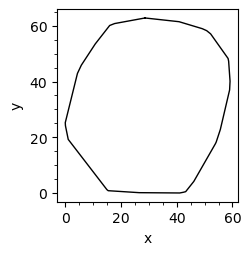

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.plot(x, y, lw=1, c="k")

ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y")

ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(5))

#### Projection Image

In [46]:
ms.vertices -= ms.bounds[0]

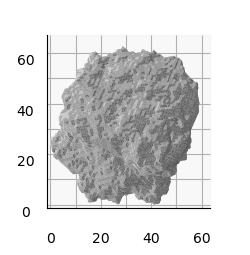

In [47]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.add_collection3d(Poly3DCollection(ms.triangles, shade=True, facecolors="white"))

ax.set_ylim(0, ms.extents[1]*1.05)
ax.set_zlim(0, ms.extents[2]*1.05)

ax.view_init(elev=0, azim=0)

ax.set_xticks([])
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))

ax.set_xlabel("x"), ax.set_ylabel("y")
ax.set_aspect("equal")
ax.set_proj_type("ortho", focal_length=None);

### Vector Analysis

In [48]:
ms = trimesh.load_mesh(file)
ms.vertices -= ms.center_mass
ms.apply_transform(ms.principal_inertia_transform)

projection = get_projection(ms, normal=(1,0,0))

#### Bounding Box from Projection

In [49]:
projection.bounds

(-31.24434452850366, -30.70986813226747, 27.884942825649944, 32.0871241453831)

In [50]:
projection.bounds[2] - projection.bounds[0], projection.bounds[3] - projection.bounds[1]

(59.129287354153604, 62.796992277650574)

In [51]:
ms.extents

array([39.51934247, 59.12928735, 62.79699228])

#### Feret Diameters

In [52]:
ferets = np.zeros((1, 2))

for angle in np.linspace(0, 180, 500): # that is in degrees
    projection_rot = shapely.affinity.rotate(projection, angle, 'center')
    bounds = np.array([[projection_rot.bounds[2] - projection_rot.bounds[0], projection_rot.bounds[3] - projection_rot.bounds[1]]])
    ferets = np.append(ferets, bounds, axis=0)

feret_min, feret_max = ferets[ferets > 0].min(), ferets.max()
feret_min, feret_max

(54.605535482010865, 67.42489454240962)

In [53]:
min_index, max_index = np.where(ferets == feret_min), np.where(ferets == feret_max)
min_index, max_index

((array([289], dtype=int64), array([1], dtype=int64)),
 (array([338], dtype=int64), array([0], dtype=int64)))

In [54]:
# this flips the second index so the other value is read
min_index[1][0] = np.where((min_index[1][0]==0)|(min_index[1][0]==1), min_index[1][0]^1, min_index[1][0])
max_index[1][0] = np.where((max_index[1][0]==0)|(max_index[1][0]==1), max_index[1][0]^1, max_index[1][0])
min_index, max_index

((array([289], dtype=int64), array([0], dtype=int64)),
 (array([338], dtype=int64), array([1], dtype=int64)))

In [55]:
feret_max90, feret_min90 = ferets[min_index[0][0], min_index[1][0]], ferets[max_index[0][0], max_index[1][0]]
feret_min90, feret_max90

(56.22610414805315, 64.97140220246159)

#### Areas

In [56]:
area, area_convex = projection.area, projection.convex_hull.area
area, area_convex

(2727.938164688693, 2926.380553848327)

#### Perimeters

In [57]:
perimeter, perimeter_convex = projection.length, projection.convex_hull.length
perimeter, perimeter_convex

(227.20782299849907, 196.29389813939707)

### Pixel Analysis

In [58]:
ms = trimesh.load_mesh(file)
ms.vertices -= ms.center_mass
ms.apply_transform(ms.principal_inertia_transform)
projection = get_projection(ms, normal=(1,0,0))

In [59]:
scale_factor = 1
x, y = projection.exterior.coords.xy
x, y = (x - np.min(x)) * scale_factor, (y - np.min(y)) * scale_factor
xy = np.column_stack([x, y])

#### Pixelization

In [60]:
bounds = projection.bounds
bounds = np.multiply(bounds, scale_factor)

bounds

array([-31.24434453, -30.70986813,  27.88494283,  32.08712415])

(None, None)

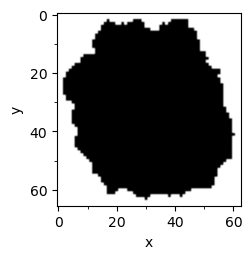

In [61]:
image = np.random.random([int(np.ceil(bounds[3] - bounds[1])) + 3, int(np.ceil(bounds[2] - bounds[0])) + 3])
mask = np.zeros(image.shape, dtype='float')

xy = np.dstack((x, y)).reshape(len(x), 2)
input_polygon = xy + 1
r, c = polygon(input_polygon[:,1], input_polygon[:,0], mask.shape)
mask[r,c] = 1

fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.imshow(mask, cmap="Grays")

ax.set_xlabel("x"), ax.set_ylabel("y")
ax.set_aspect('equal')

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))

#### Convex Hull

In [62]:
labeled = label(mask)

In [63]:
props = regionprops(labeled)

In [64]:
convex_hull = convex_hull_image(mask)

(None, None)

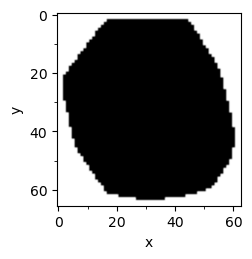

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.imshow(convex_hull, cmap="Grays")

ax.set_aspect('equal')
ax.set_xlabel("x"), ax.set_ylabel("y")

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))

In [66]:
labeled = label(convex_hull)

In [67]:
props_convex = regionprops(labeled)

#### Areas

In [68]:
area, area_convex = props[0]["area"], props_convex[0]["area"]
area, area_convex

(2720.0, 2923.0)

#### Perimeters

In [69]:
perimeter, perimeter_convex = props[0]["perimeter"], props_convex[0]["perimeter"]
perimeter, perimeter_convex

(224.5512985522207, 202.8528137423857)

#### Feret Diameters

In [75]:
feret_max = props[0]["feret_diameter_max"]
feret_max

67.7421582177598

In [76]:
feret.all(mask)

(66.88796603276258, 53.65246392520946, 64.13101344315324, 55.36122892698253)

In [77]:
feret.all(mask, edge=True)

(68.26419266350405, 54.85492042726858, 65.33346994521236, 56.77940145144672)

#### Image Inversion

In [78]:
mask_inverted = mask.copy() * -1 + 1

mask_inverted

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

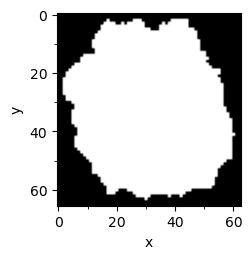

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.imshow(mask_inverted, cmap="Grays")

ax.set_aspect('equal')
ax.set_xlabel("x"), ax.set_ylabel("y")

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10));

#### Image Scale-Up

In [82]:
scale_factor = 2
x, y = projection.exterior.coords.xy
x, y = (x - np.min(x)) * scale_factor, (y - np.min(y)) * scale_factor
xy = np.column_stack([x, y])
bounds = projection.bounds
bounds = np.multiply(bounds, scale_factor)

In [83]:
image = np.random.random([int(np.ceil(bounds[3] - bounds[1])) + 3, int(np.ceil(bounds[2] - bounds[0])) + 3])
mask = np.zeros(image.shape, dtype='float')

In [84]:
xy = np.dstack((x, y)).reshape(len(x), 2)
input_polygon = xy + 1
r, c = polygon(input_polygon[:,1], input_polygon[:,0], mask.shape)
mask[r,c] = 1

#### Maximum Inscribed Circle

In [85]:
im_dist = distance_transform_edt(mask)

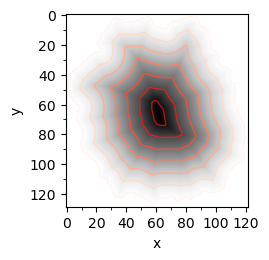

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.imshow(im_dist, cmap="Grays")
ax.contour(im_dist, linewidths=1, cmap="Reds")

ax.set_aspect('equal')
ax.set_xlabel("x"), ax.set_ylabel("y")

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10));

In [88]:
max_coord = np.where(im_dist == im_dist.max())
x_inner, y_inner = np.array(max_coord).flatten()
radius_inner = int(im_dist.max())

x_inner, y_inner, radius_inner

(69, 62, 51)

In [103]:
img = mask_inverted.copy()

# anti-aliased line
rr, cc, val = circle_perimeter_aa(int(x_inner / scale_factor), int(y_inner / scale_factor), int(radius_inner / scale_factor))
img[rr, cc] = val

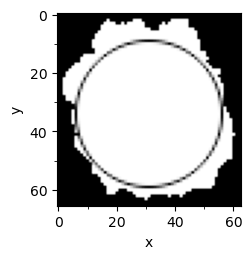

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.imshow(img, cmap="Grays")

ax.set_aspect('equal')
ax.set_xlabel("x"), ax.set_ylabel("y")

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10));

#### Minimum Enclosing Circle

In [99]:
mask_cv = mask.astype(np.uint8)
mask_cv = mask_cv * 255
contours, _ = cv.findContours(mask_cv, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
(x, y), radius = cv.minEnclosingCircle(contours[0])

x, y, radius

(64.72724914550781, 61.72688674926758, 67.23045349121094)

In [101]:
x_outer, y_outer, radius_outer = int(x), int(y), int(radius)
x_outer, y_outer, radius_outer

(64, 61, 67)

In [115]:
pad = 15

mask_show = np.pad(mask, pad)
# enclosing circle
rr, cc, val = circle_perimeter_aa(int(y_outer + pad), int(x_outer + pad), int(radius_outer))
mask_show[rr, cc] = val
# inscribed circle
rr, cc, val = circle_perimeter_aa(int(x_inner + pad), int(y_inner + pad), int(radius_inner))
mask_show[rr, cc] = val * -1 + 1

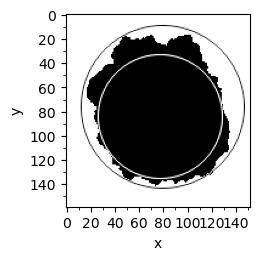

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.imshow(mask_show, cmap="Grays")

ax.set_aspect('equal')
ax.set_xlabel("x"), ax.set_ylabel("y")

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10));

In [117]:
radius_outer / 2

33.5

## Stable Positions

In [118]:
ms = trimesh.load_mesh(file)

### Positions

In [119]:
transforms, probabilities = ms.compute_stable_poses()
probabilities

array([0.40297298, 0.31502987, 0.16708065, 0.03422142, 0.01428941,
       0.01174768, 0.01092668, 0.00760193, 0.00713923, 0.00646226,
       0.00628863, 0.0060652 , 0.00265203, 0.00263002, 0.00211041,
       0.0017103 , 0.0010713 ])

In [120]:
valid_probs = probabilities[probabilities > 0.1]
if len(valid_probs) < 2:
    valid_probs = probabilities[:2]
valid_probs

array([0.40297298, 0.31502987, 0.16708065])

In [121]:
for i in range(len(valid_probs)):
    print(transforms[i])

[[ 0.20395425 -0.97898042  0.          0.        ]
 [ 0.68485245  0.14267759  0.71457695  0.        ]
 [-0.69955684 -0.14574101  0.69955684 19.03377582]
 [ 0.          0.          0.          1.        ]]
[[ 0.6         0.8         0.          0.        ]
 [ 0.49975604 -0.37481703  0.78086881  0.        ]
 [ 0.62469505 -0.46852129 -0.62469505 31.70327366]
 [ 0.          0.          0.          1.        ]]
[[ -0.57787669   0.81612409   0.           0.        ]
 [  0.0330689    0.02341524   0.99917875   0.        ]
 [  0.81545385   0.57740211  -0.04051945 -18.70732173]
 [  0.           0.           0.           1.        ]]


### Alignment and Projection

In [122]:
ms = trimesh.load_mesh(file)
ms.apply_transform(transforms[0])
ms.vertices -= ms.bounds[0];

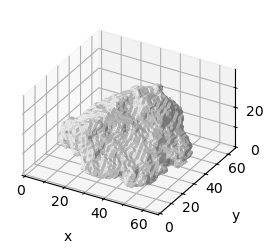

In [123]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.add_collection3d(Poly3DCollection(ms.triangles, shade=True, facecolors="white"))

ax.set_xlim(0, ms.extents[0] * 1.02)
ax.set_ylim(0, ms.extents[1] * 1.02)
ax.set_zlim(0, ms.extents[2] * 1.02)

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))

ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0)
ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z");

**Normals have changed!**

In [126]:
projection = get_projection(ms, normal=(0,0,1))
x, y = projection.exterior.xy
x, y = np.array(x), np.array(y)
x, y = x - x.min(), y - y.min()

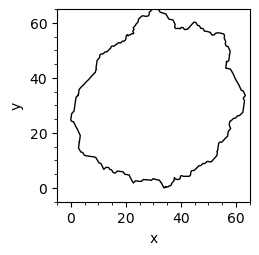

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.plot(x, y, lw=1, c="k")

ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y")

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_xlim(-5, 65), ax.set_ylim(-5, 65);

In [128]:
ms = trimesh.load_mesh(file)
ms.apply_transform(transforms[1])
ms.vertices -= ms.bounds[0];

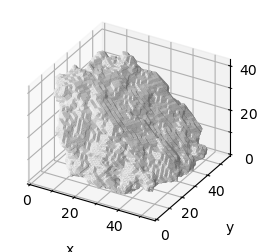

In [129]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.add_collection3d(Poly3DCollection(ms.triangles, shade=True, facecolors="white"))

ax.set_xlim(0, ms.extents[0] * 1.02)
ax.set_ylim(0, ms.extents[1] * 1.02)
ax.set_zlim(0, ms.extents[2] * 1.02)

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))

ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0)
ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z");

In [130]:
projection = get_projection(ms, normal=(0,0,1))
x, y = projection.exterior.xy
x, y = np.array(x), np.array(y)
x, y = x - x.min(), y - y.min()

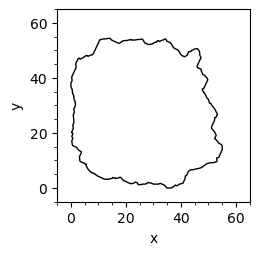

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.plot(x, y, lw=1, c="k")

ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y")

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_xlim(-5, 65), ax.set_ylim(-5, 65);

In [132]:
ms = trimesh.load_mesh(file)
ms.apply_transform(transforms[2])
ms.vertices -= ms.bounds[0];

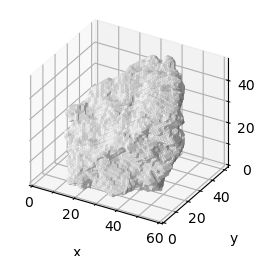

In [133]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.add_collection3d(Poly3DCollection(ms.triangles, shade=True, facecolors="white"))

ax.set_xlim(0, ms.extents[0] * 1.02)
ax.set_ylim(0, ms.extents[1] * 1.02)
ax.set_zlim(0, ms.extents[2] * 1.02)

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))

ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0)
ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z");

In [134]:
projection = get_projection(ms, normal=(0,0,1))
x, y = projection.exterior.xy
x, y = np.array(x), np.array(y)
x, y = x - x.min(), y - y.min()

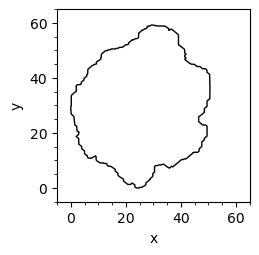

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.plot(x, y, lw=1, c="k")

ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y")

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_xlim(-5, 65), ax.set_ylim(-5, 65);

# Dynamic Image Analysis

In [136]:
ms = trimesh.load_mesh(file)

## Rotation and Projection

In [137]:
ms.vertices -= ms.center_mass
ms.apply_transform(trimesh.transformations.random_rotation_matrix());

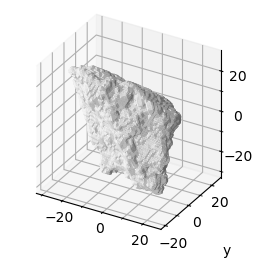

In [138]:
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.add_collection3d(Poly3DCollection(ms.triangles, shade=True, facecolors="white"))

ax.set_xlim(ms.bounds[0][0], ms.bounds[1][0])
ax.set_ylim(ms.bounds[0][1], ms.bounds[1][1])
ax.set_zlim(ms.bounds[0][2], ms.bounds[1][2])

ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.zaxis.set_major_locator(MultipleLocator(20)), ax.zaxis.set_minor_locator(MultipleLocator(10))

ax.tick_params(axis='x', pad=-3.5), ax.tick_params(axis='y', pad=-2.5), ax.tick_params(axis='z', pad=0)
ax.set_aspect("equal")
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z");

In [139]:
projection = get_projection(ms, normal=(0,0,1))
x, y = projection.exterior.xy
x, y = np.array(x), np.array(y)
x, y = x - x.min(), y - y.min()

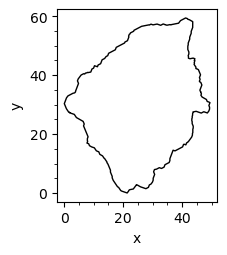

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.plot(x, y, lw=1, c="k")

ax.set_aspect("equal")
ax.xaxis.set_major_locator(MultipleLocator(20)), ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(20)), ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_xlabel("x"), ax.set_ylabel("y");